In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV, permutation_test_score, cross_val_score, ShuffleSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, mean_squared_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.metrics.cluster import contingency_matrix
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance

from statsmodels.stats.contingency_tables import mcnemar
from scipy.spatial.distance import euclidean

import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.lines import Line2D
import numpy as np
from itertools import chain, combinations
import networkx as nx
from collections import Counter
import seaborn as sns
import pickle
# import verstack

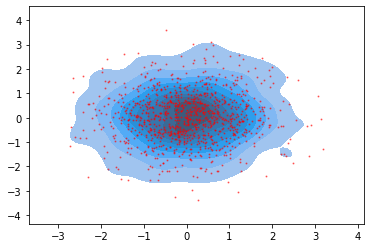

In [50]:
xy=np.array(np.random.randn(1000,2))
# xy=np.array(np.random.random((1000,2)))
# xy = np.random.gamma(1, 10, (1000, 2))
sns.kdeplot(x=xy[:,0], y=xy[:,1], fill=True)
plt.scatter(xy[:,0], xy[:,1], s=1, color='red', alpha=0.5)

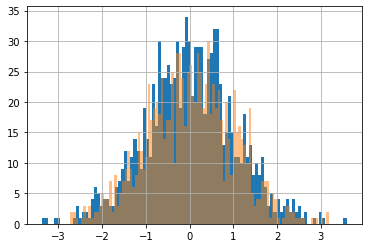

In [51]:
ax = plt.hist(xy[:,1], bins=100)
ax = plt.hist(xy[:,0], bins=100, alpha=0.5)
plt.grid()

In [52]:
from itertools import combinations

dists = []

for _ in list(combinations(xy, 2)):
    dists += [euclidean(_[0], _[1])]
#     dists += [_[0]-_[1]]

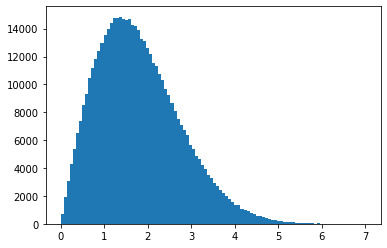

In [53]:
ax = plt.hist(dists, bins=100)

In [6]:
summ = [i[0] + i[1] for i in combinations(dists[1:1000], 2)]
len(summ)

498501

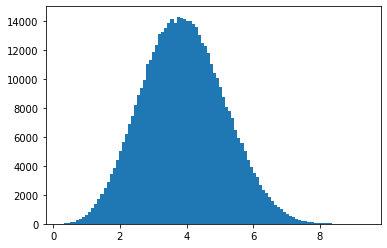

In [7]:
ax = plt.hist(summ, bins=100)

## 1. Data

In [8]:
data = pd.read_csv('new_results_updated_plus_fam_i.csv', index_col=1)
data['Contact'] = np.where(data['Distance'] > 1000, 'No', 'Yes')
data.head(3)

,Unnamed: 0,Language 1,Language 2,Pair,N_sh_colex,N_sh_concepts,Distance,Same_family,Same_genus,WMCD,WMCD_i,Population_difference,Sum_of_n_colex,Jaccard,Population_difference_log,Family_1,Family_2,Contact
Unnamed: 0.1,,,,,,,,,,,,,,,,,,
0,0,Abkhaz,Adyghe,Abkhaz + Adyghe,23,902,199.830288,yes,no,0.123631,0.048653,385790.0,267,0.094262,12.863048,Abkhaz-Adyge,Abkhaz-Adyge,Yes
1,1,Abkhaz,Hokkaido Ainu,Abkhaz + Hokkaido Ainu,9,849,7612.530408,no,no,0.050646,0.019121,190108.0,258,0.036145,12.155348,Abkhaz-Adyge,Ainu,No
2,2,Abkhaz,Aleut,Abkhaz + Aleut,15,890,8899.674611,no,no,0.086651,0.036300,189960.0,244,0.065502,12.154569,Abkhaz-Adyge,Eskimo-Aleut,No


In [9]:
data.shape

(5460, 18)

In [10]:
data = data.dropna()
data = data[data['Population_difference'] > 0]

In [11]:
data.shape

(4941, 18)

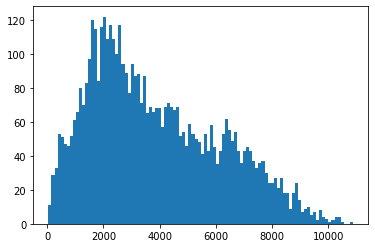

In [12]:
ax = plt.hist(data['Distance'], bins=100)

In [13]:
y = data.WMCD
X = data[['Distance', 'Same_family', 'Same_genus', 'Contact', 'Population_difference']]

## 2. Model tuning

In [14]:
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()
# or try to use scaler instead of simply passing the values trough
preprocessor = ColumnTransformer(transformers=[
    ('impute','passthrough', selector(dtype_include='float64')),
    ('cat', categorical_transformer, selector(dtype_include="object"))
])

In [15]:
params = {"max_depth": [2, 3, 4, 5, 6], 
          "n_estimators": [20, 50, 75, 100, 150, 200, 250, 300, 500, 1000, 2000],
#           "random_state": [42], 
          'learning_rate': [_/100 for _ in range(1, 10)], 
          'max_depth': [_ for _ in range(2, 10)], 
          'alpha': [_/10 for _ in range(1, 10)]}

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.33, random_state=41)

In [17]:
X_train.shape

(3310, 5)

In [18]:
X_test.shape

(1631, 5)

In [19]:
cr_v = ShuffleSplit(n_splits=5, test_size=0.3)
# cv = GridSearchCV(GradientBoostingRegressor(), params, cv=cr_v, n_jobs=4, verbose=True)
# cv.fit(preprocessor.fit_transform(X_train), y_train)

In [20]:
# r2_score(y_test, cv.predict(preprocessor.fit_transform(X_test)))

In [21]:
# mean_squared_error(y_test, cv.predict(preprocessor.fit_transform(X_test)))

In [22]:
# r2_score(y_train, cv.predict(preprocessor.fit_transform(X_train)))

In [23]:
# mean_squared_error(y_train, cv.predict(preprocessor.fit_transform(X_train)))

In [24]:
# cv.best_params_

In [25]:
# with open('best_params_gbr.p', 'wb') as file:
#     pickle.dump(cv.best_params_, file)

In [26]:
with open('best_params_gbr.p', 'rb') as file:
    best_params = pickle.load(file)

In [27]:
best_params

{'alpha': 0.4, 'learning_rate': 0.09, 'max_depth': 4, 'n_estimators': 150}

## 3. Analysis

In [28]:
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()
preprocessor = ColumnTransformer(transformers=[
    ('impute','passthrough', selector(dtype_include='float64')),
    ('cat', categorical_transformer, selector(dtype_include="object"))
])
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GradientBoostingRegressor(**best_params))])

# clf.fit(X_train, y_train)

In [29]:
# res = cross_val_score(clf, X_valid, y_valid, scoring='neg_mean_squared_error', cv=10)
# print('train: mean r2: {} --- sd r2: {}'.format(np.mean(res), np.std(res)))

In [30]:
# perm_t = permutation_test_score(clf, X, y, scoring='r2', cv=5, n_jobs=2, n_permutations=200)
# print(' Score: {} \n p value: {}'.format(perm_t[0], perm_t[2]))

Using: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.permutation_test_score.html#sklearn.model_selection.permutation_test_score

In [31]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('impute', 'passthrough',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f95705a49d0>),
                                                 ('cat',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown=...
                                           learning_rate=0.09, loss='ls',
                                           max_depth=4, max_features=None,
        

In [32]:
round(r2_score(y_train, clf.predict(X_train)), 3)

0.604

In [33]:
round(r2_score(y_test, clf.predict(X_test)), 3)

0.454

In [34]:
cv = ShuffleSplit(n_splits=5, test_size=0.3)
scores = []
for _ in range(10):
    scores += list(cross_val_score(clf, X, y, scoring="r2", cv=cv))
    
print('Mean: {}, Std: {}'.format(round(np.mean(scores), 3), round(np.std(scores), 3)))

Mean: 0.404, Std: 0.023


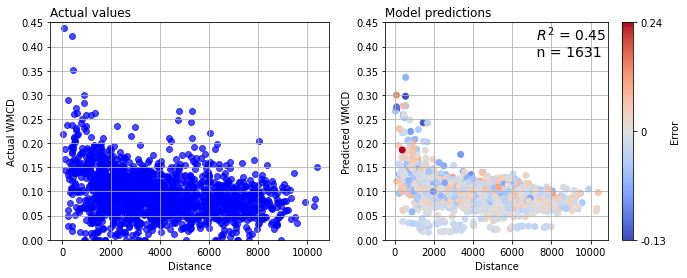

In [35]:
pred = clf.predict(X_test)
offset = y_test-pred

off = colors.TwoSlopeNorm(vmin=min(offset),
                                  vcenter=0, vmax=max(offset))
plt.figure(figsize=(11, 4))
plt.subplot(1, 2, 2)
# plt.scatter(X_valid['Distance'], y_valid, alpha=1, color='green')
plt.scatter(X_test['Distance'], pred, label='Predicted', 
            c=off(offset), alpha=1, cmap='coolwarm')
clb = plt.colorbar(ticks=[0, 0.5, 1])
clb.ax.set_yticklabels([str(round(min(offset), 2)), '0', str(round(max(offset), 2))])
clb.set_label('Error')
plt.text(x=7000, y=0.38, fontsize=14,
         s=' $R^2$ = {} \n n = {}'.format(round(r2_score(y_test, clf.predict(X_test)), 2), 
                                          len(y_test)))
plt.xlabel('Distance')
plt.ylim((0, 0.45))
plt.ylabel('Predicted WMCD')
plt.title('Model predictions', loc='left')
plt.grid()

plt.subplot(1, 2, 1)
plt.scatter(X_test['Distance'], y_test, alpha=0.7, color='blue')
plt.xlabel('Distance')
plt.ylabel('Actual WMCD')
plt.ylim((0, 0.45))
plt.title('Actual values', loc='left')
plt.grid()

plt.savefig('GBR_WMCD_valid.pdf', dpi=300)

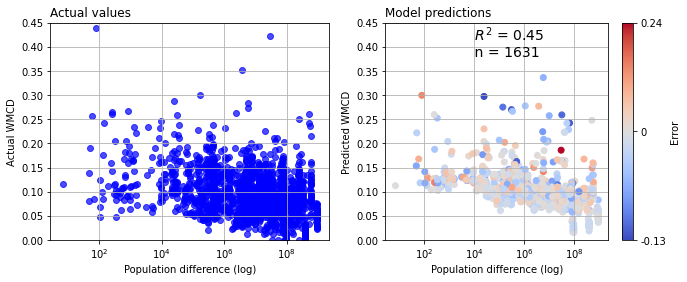

In [36]:
pred = clf.predict(X_test)
offset = y_test-pred

off = colors.TwoSlopeNorm(vmin=min(offset),
                                  vcenter=0, vmax=max(offset))
plt.figure(figsize=(11, 4))
ax = plt.subplot(1, 2, 2)
# plt.scatter(X_valid['Distance'], y_valid, alpha=1, color='green')
plt.scatter(X_test['Population_difference'], pred, label='Predicted', 
            c=off(offset), alpha=1, cmap='coolwarm')
clb = plt.colorbar(ticks=[0, 0.5, 1])
clb.ax.set_yticklabels([str(round(min(offset), 2)), '0', str(round(max(offset), 2))])
clb.set_label('Error')
plt.text(x=7000, y=0.38, fontsize=14,
         s=' $R^2$ = {} \n n = {}'.format(round(r2_score(y_test, clf.predict(X_test)), 2), 
                                          len(y_test)))
plt.xlabel('Population difference (log)')
plt.ylim((0, 0.45))
plt.ylabel('Predicted WMCD')
plt.title('Model predictions', loc='left')
ax.set_xscale('log')
plt.grid()

ax2 = plt.subplot(1, 2, 1)
plt.scatter(X_test['Population_difference'], y_test, alpha=0.7, color='blue')
plt.xlabel('Population difference (log)')
plt.ylabel('Actual WMCD')
plt.ylim((0, 0.45))
plt.title('Actual values', loc='left')
ax2.set_xscale('log')
plt.grid()

plt.savefig('GBR_WMCD_valid_pop_diff.pdf', dpi=300)

In [37]:
round(np.mean(np.abs(offset)), 3)

0.028

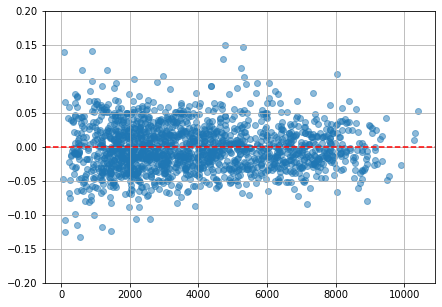

In [38]:
plt.figure(figsize=(7, 5))
plt.scatter(X_test['Distance'], (y_test-pred), alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.ylim(-0.2, +0.2)
plt.grid()

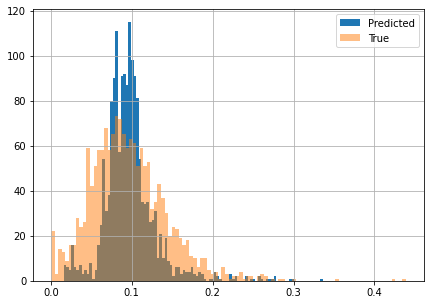

In [39]:
plt.figure(figsize=(7, 5))
ax = plt.hist(clf.predict(X_test), bins=100, label='Predicted')
ax2 = plt.hist(y_test, bins=100, alpha=0.5, label='True')
plt.legend()
plt.grid()

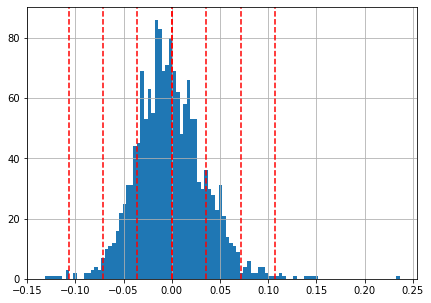

In [40]:
plt.figure(figsize=(7, 5))
ax = plt.hist(y_test-clf.predict(X_test), bins=100)
for i in range(4):
    plt.axvline(i*np.std(y_test-clf.predict(X_test)), color='red', linestyle='--')
    plt.axvline(-i*np.std(y_test-clf.predict(X_test)), color='red', linestyle='--')
plt.grid()

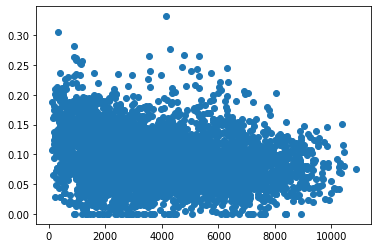

In [41]:
plt.scatter(data[data.Same_genus == 'no'].Distance, data[data.Same_genus == 'no'].WMCD)

### 3.1. Feature importance

In [42]:
result = permutation_importance(clf, X_train, y_train, n_repeats=200, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
results_perm = pd.DataFrame(result.importances[sorted_idx].T, columns=np.array(X.columns)[sorted_idx])
results_perm = results_perm.unstack().reset_index().drop(['level_1'], axis=1)
results_perm.columns = ['Variable', 'Importance']
results_perm['Set'] = 'Train'
results_perm.head(10)
results_perm_train = results_perm

In [43]:
result = permutation_importance(clf, X_test, y_test, n_repeats=200, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
results_perm = pd.DataFrame(result.importances[sorted_idx].T, columns=np.array(X.columns)[sorted_idx])
results_perm = results_perm.unstack().reset_index().drop(['level_1'], axis=1)
results_perm.columns = ['Variable', 'Importance']
results_perm['Set'] = 'Test'
results_perm.head(10)
results_perm_test = results_perm

In [44]:
pd.concat([results_perm, results_perm_train], axis=0).to_csv('combined_importance.csv')

In [45]:
res_importance = pd.concat([results_perm, results_perm_train], axis=0)

### 3.1.1. Examining the decision trees

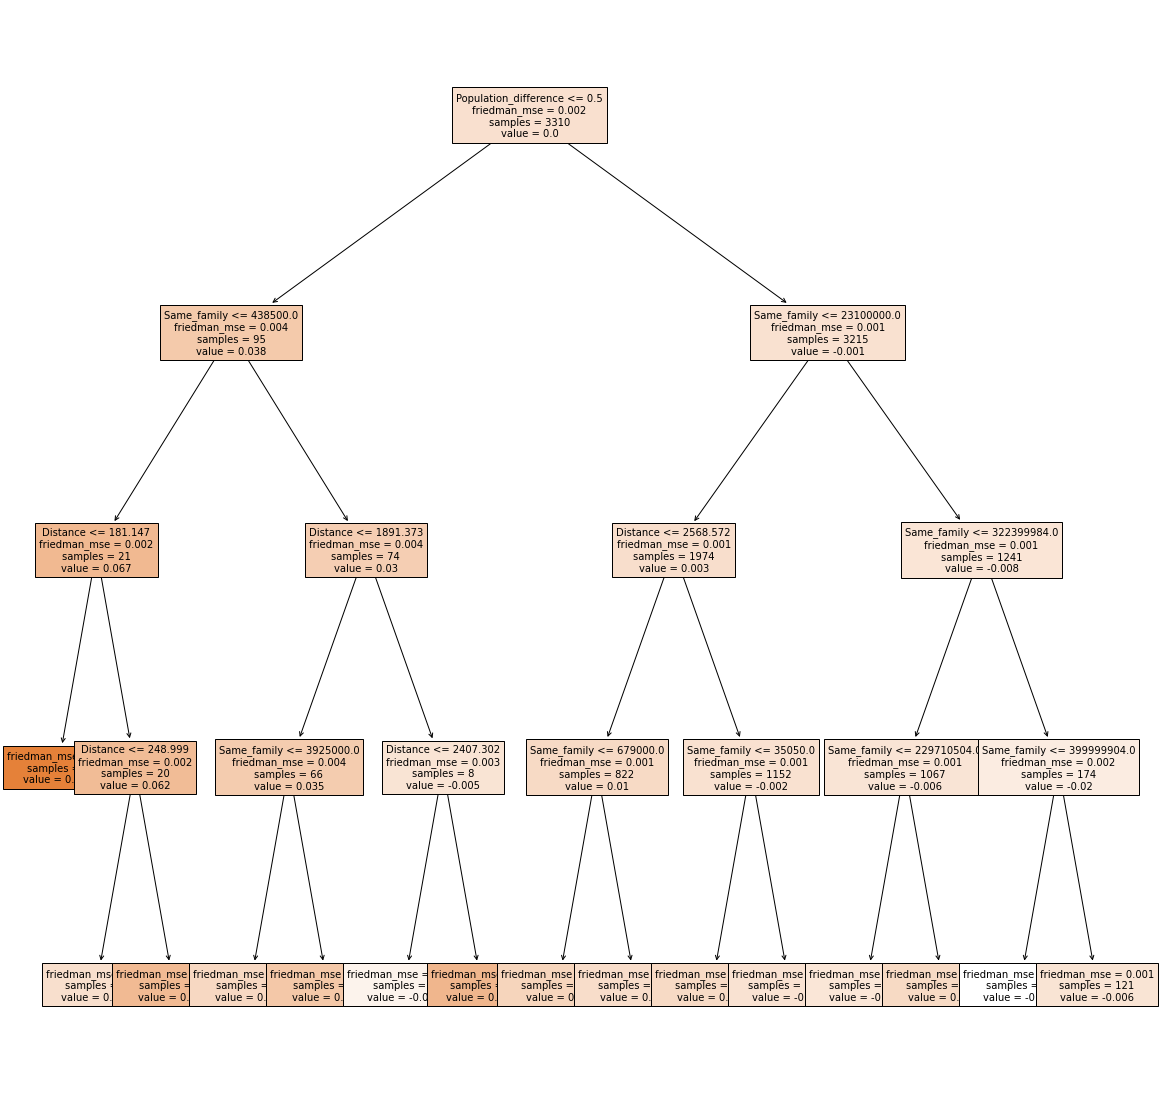

In [46]:
plt.figure(figsize=(20, 20))
ax = plot_tree(clf['classifier'].estimators_[10][0],
               feature_names=X.columns, 
               filled=True, fontsize=10)

### 3.2. Model comparison

Does contact deletion produce difference?

In [47]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GradientBoostingRegressor(**best_params))])
X_train, X_test, y_train, y_test = train_test_split(data[['Distance', 
                                                          'Same_family',
                                                          'Same_genus',
                                                          'Population_difference']], y, test_size=0.33, 
                                                    random_state=41)
clf.fit(X_train, y_train)
model1_pred = clf.predict(X_test)

In [48]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GradientBoostingRegressor(**best_params))])
X_train, X_test, y_train, y_test = train_test_split(data[['Distance', 
                                                          'Same_family',
                                                          'Same_genus',
                                                          'Population_difference', 
                                                          'Contact']], y, test_size=0.33, 
                                                    random_state=41)
clf.fit(X_train, y_train)
model2_pred = clf.predict(X_test)

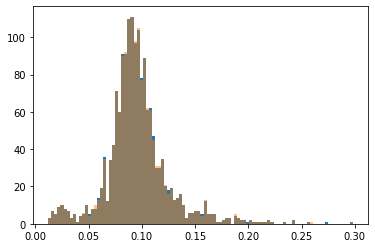

In [49]:
ax = plt.hist(model2_pred, bins=100)
ax = plt.hist(model1_pred, bins=100, alpha=0.5)